IMPORTS

In [4]:
import numpy as np 
from PIL import Image 
import os 
import cv2 
import math 
import matplotlib.pyplot as plt 

CUSTOM CLASS

In [5]:
# custom class to store image pairs  
class ImagePair:
    def __init__(self, img, pred):
        self.img = img
        self.pred = pred 

    def __repr__(self):
        return f"ImagePair(img={self.img}, pred={self.pred})" 

# custom class to store list of image pairs from directories 
class ImagePairSet:
    def __init__(self, img_dir, pred_dir, img_size):
        self.img_dir = img_dir
        self.pred_dir = pred_dir
        self.img_size = img_size 
        self.img_paths = self.list_images(img_dir) 
        self.pred_paths = self.find_corresponding_preds(pred_dir) 
        self.image_pairs = self.create_image_pairs() 

    def list_images(self, img_dir): 
        # read all images from directory and return list of image paths 
        img_paths = []
        for img in os.listdir(img_dir):
            if img.endswith(".png"):
                img_paths.append(img_dir + img)
        return img_paths 
    
    def find_corresponding_preds(self, pred_dir):
        # find corresponding predictions for each image in img_dir
        pred_paths = []
        for img_path in self.img_paths:
            img_name = img_path.split('/')[-1]
            pred_path = pred_dir + img_name.replace(".png","_prediction.png")
            pred_paths.append(pred_path)
        return pred_paths 
    
    def create_image_pairs(self):
        # create list of image pairs 
        image_pairs = []
        for i in range(len(self.img_paths)):
            img = Image.open(self.img_paths[i])
            # downsize img to img_size 
            img = img.resize(self.img_size, Image.Resampling.LANCZOS) 
            pred = Image.open(self.pred_paths[i])
            image_pairs.append(ImagePair(img, pred))
        return image_pairs

HELPER FUNCTIONS 

In [6]:
def fit_parallelogram(binary_image):
    binary_image = np.array(binary_image)   
    # Ensure the input image is binary (already thresholded)
    if len(binary_image.shape) == 3:  # In case the image is a color image (unexpected)
        binary_image = cv2.cvtColor(binary_image, cv2.COLOR_BGR2GRAY)
    
    # Find contours from the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    parallelogram_corners = None

    for contour in contours:
        # Check if the contour is large enough to be considered
        area = cv2.contourArea(contour)
        if area < 100:  # Threshold for ignoring small contours (adjust as needed)
            continue

        # Approximate the contour to a polygon (reduce epsilon for higher accuracy)
        epsilon = 0.02 * cv2.arcLength(contour, True)  # Reduce epsilon for more accuracy
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # If the contour has more than 4 points, apply convex hull and approximate again
        if len(approx) > 4:
            hull = cv2.convexHull(contour)
            epsilon = 0.02 * cv2.arcLength(hull, True)  # Reduce epsilon for more accuracy
            approx = cv2.approxPolyDP(hull, epsilon, True)
            
            return None # TODO: add way to handle this case by predicting 4th corner  

        # Check if the polygon has 4 sides (quadrilateral)
        if len(approx) == 4:
            parallelogram_corners = approx.reshape(4, 2)
            break  # Stop after finding the first valid parallelogram
    
    return parallelogram_corners

def se3_to_perspective_transform(SE3_matrix, camera_matrix):
    """
    Converts an SE3 (Special Euclidean Group in 3D) transformation matrix to a perspective transformation matrix.

    Parameters:
    - SE3_matrix (np.array): A 4x4 transformation matrix representing the rotation and translation.
    - camera_matrix (np.array): A 3x3 camera intrinsic matrix (e.g., K matrix).

    Returns:
    - np.array: A 3x3 perspective transformation matrix.
    """
    # Extract the rotation matrix (3x3) and translation vector (3x1) from the SE3 matrix
    R = SE3_matrix[:3, :3]  # Rotation matrix
    t = SE3_matrix[:3, 3]   # Translation vector

    # Combine R and t into a 3x4 matrix (Rotation + Translation)
    Rt = np.hstack((R, t.reshape(-1, 1)))  # Combine R and t into a 3x4 matrix

    # Compute the perspective transformation matrix: K * [R | t]
    H = camera_matrix @ Rt  # Perspective transformation matrix (3x3)
    H = H[:3,:3] 

    return H

def marker_reprojection(image, pred, marker_image, marker_corners_2d, marker_corners_3d, rvec, tvec, camera_matrix, dist_coeffs, alpha):
    # Load the image and marker image 
    image = np.array(image) 
    if image.shape[2] == 4: 
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB) 
    marker_image = np.array(marker_image) 

    # Project the 3D model points of the marker to the image
    image_points, _ = cv2.projectPoints(marker_corners_3d, rvec, tvec, camera_matrix, dist_coeffs)

    # Convert the image points to integer
    image_points = np.round(image_points).astype(int)

    # Draw the marker on the image 
    reprojected_marker_mask = cv2.fillPoly(image*0, [image_points], (255, 255, 255)) 

    image = cv2.addWeighted(image, alpha, pred, 1 - alpha, 0) 

    marker_image_corners = np.array([
        [0, 0],
        [marker_image.shape[1], 0],
        [marker_image.shape[1], marker_image.shape[0]],
        [0, marker_image.shape[0]] 
    ], dtype=np.float32)

    image_points = np.array(image_points).reshape(-1, 2).astype(np.float32)
    M = cv2.getPerspectiveTransform(marker_image_corners, image_points) 

    # define overlay to be each pixel of the marker image transformed using H 
    reprojected_marker_image = cv2.warpPerspective(marker_image, M, (image.shape[1], image.shape[0])) 
    blended_image = cv2.addWeighted(image, 1-alpha, reprojected_marker_image, alpha, 0) 
    
    return reprojected_marker_image, reprojected_marker_mask, blended_image    

def image_overlap_error(img, img_mask, pred, pred_mask): 

    filter = "mean_threshold" # "min_max", "local", "mean_threshold"

    img = np.array(img) 
    if img.shape[2] == 4:   
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB) 
    img_mask = np.array(img_mask) 
    pred = np.array(pred) 
    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY) # convert pred to grayscale 
    pred_mask = np.array(pred_mask) 

    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    

    binary_mask = img_mask.copy() 
    binary_mask[binary_mask > 0] = 255 

    masked_pixels = img[img_mask == 255]

    if filter == "min_max": 
        # Find the minimum and maximum pixel values in the masked region
        min_pixel_value = np.min(masked_pixels)
        max_pixel_value = np.max(masked_pixels)

        # normalize img using range of img_mask 
        img_dot_mask = cv2.bitwise_and(img, img_mask)     
        img_filtered = cv2.normalize(img_dot_mask, None, min_pixel_value, max_pixel_value, cv2.NORM_MINMAX) 
    elif filter == "local":
        # TODO: localized regions normalization 
        pass 
    elif filter == "mean_threshold": 
        img_masked_mean = masked_pixels.mean() 
        # threshold img using img_masked_mean as threshold 
        _, img_filtered = cv2.threshold(img_grey, img_masked_mean, 255, cv2.THRESH_BINARY) 
        img_filtered = np.array(img_filtered)

    intersection = cv2.bitwise_and(img_mask, pred_mask) 

    # for each pixel of intersection, compute error between img and pred 
    error = 0 
    for i in range(intersection.shape[0]):
        for j in range(intersection.shape[1]):
            if intersection[i][j][0] == 255:

                # error += np.linalg.norm(img_filtered[i][j] - pred[i][j]) 
                
                if img_filtered[i][j] == pred[i][j]: 
                    error -= 1 
                
                # error += np.sum((img_grey[i][j] - pred[i][j]) ** 2)
    return error 


READ IMAGES

In [7]:
# dir_images = "../segmentation_model/test_images_real/test_images_20250313/" 
# dir_predictions = "../segmentation_model/test_images_real/predictions_20250313-210643/predictions/" 

dir_images = "../segmentation_model/sim_data/markers_20250314-181037/rgb/" 
dir_predictions = "../segmentation_model/sim_data/markers_20250314-181037/rgb/predictions_20250315-162709/predictions/" 

# create ImagePairSet object
image_pair_set = ImagePairSet(dir_images, dir_predictions, img_size=(640, 480)) 
print(f"Number of images: {len(image_pair_set.image_pairs)}")

Number of images: 1001


TODO: 

* compute pose using aruco 
* compute pose using optimization 
* read true pose from sim data 
* compare error 
* loop over all images 


In [8]:
# define marker corners in marker frame 
marker_img_path = "../synthetic_data_generation/assets/tags/tag36h11_0.png" 
marker_img = cv2.imread(marker_img_path) 
marker_side_length = 0.100 # measured with calipers 
marker_corners_3d = [
    [+marker_side_length/2,0,0], 
    [0,+marker_side_length/2,0], 
    [-marker_side_length/2,0,0], 
    [0,-marker_side_length/2,0]
] 
marker_corners_3d = np.array(marker_corners_3d, dtype=np.float32)

camera = "isaac" # isaac, iphone, ipad 

if camera == "isaac": 
    # assume isaac sim default 
    width = 640 
    height = 480 
    focal_length = 24.0 
    horiz_aperture = 20.955
    # Pixels are square so we can do:
    vert_aperture = height/width * horiz_aperture
    fov = 2 * math.atan(horiz_aperture / (2 * focal_length))
    # compute focal point and center
    fx = width * focal_length / horiz_aperture
    fy = height * focal_length / vert_aperture
    cx = width / 2
    cy = height /2 
else: 
    if camera == "iphone": 
        # assume iphone camera default 
        fx = 2940 / 10000
    if camera == "ipad": 
        # assume ipad camera default 
        fx = 3580  
    fxy = 2940 / 10000 # for iphone camera (approx)
    fxy = 3580 # for ipad camera (approx)
    fx = fxy 
    fy = fxy 
    cx = 640/2  
    cy = 480/2  

camera_matrix = np.array([
    [fx,0,cx],
    [0,fy,cy],
    [0,0,1]
])

-4621
-4932
-6003
-4975
-5082
-5086
-4836
-4907
Beginning optimization loop...
Solution at iteration 0: [ 11. 182.   1. 103.  84. 102.  92. 180.]
Reprojection error at iteration 0: -6003.0
Solution at iteration 1: [ 11.05457273 182.00329835   1.6003     103.00582816  84.00714643
 102.00588529  92.006525   180.003335  ]
Reprojection error at iteration 1: -6003.0
Tiny gradient! Gradient: [0. 0. 0. 0. 0. 0. 0. 0.]
Solution at iteration 2: [ 11.05240274 181.99478024   1.6093379  103.01272744  84.00305437
 102.00608124  92.01340141 180.0005488 ]
Reprojection error at iteration 2: -6003.0
Tiny gradient! Gradient: [-0. -0.  0.  0. -0.  0.  0. -0.]
Solution at iteration 3: [ 11.05016745 181.9855369    1.6106192  103.00533549  84.00540114
 102.01446633  92.01786067 180.00605788]
Reprojection error at iteration 3: -6003.0
Tiny gradient! Gradient: [-0. -0.  0. -0.  0.  0.  0.  0.]
Solution at iteration 4: [ 11.05650321 181.98689412   1.60759043 103.01290703  84.00162443
 102.00599351  92.01845176

Text(0.5, 1.0, 'Reprojection Error vs Iteration')

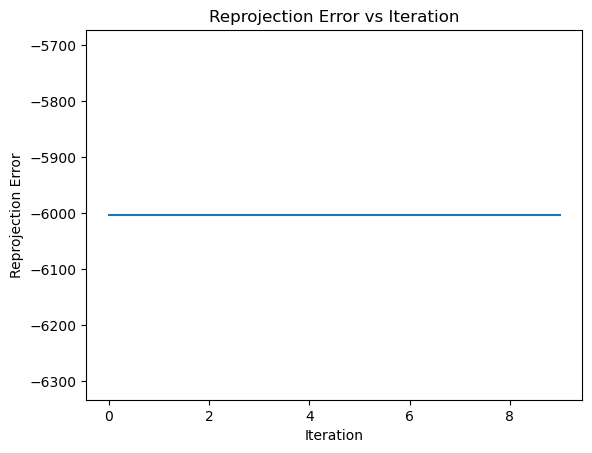

In [13]:
# loop through image pairs 
img_index = 0 
for index, image_pair in enumerate(image_pair_set.image_pairs):

    if index == img_index: # select specific image 
        img = image_pair.img
        pred = image_pair.pred

        # show selected image pair 
        # img.show()
        # pred.show()

        # (1) find initial solution for pose of marker 

        # fit parallelogram to pred image 
        marker_corners_2d = fit_parallelogram(pred) 

        if marker_corners_2d is None: 
            print("No parallelogram found in prediction image.") 
            continue 

        # draw parallelogram on pred image
        pred_np = np.array(pred)
        # cv2.polylines(pred_np, [marker_corners_2d], True, (255, 0, 0), 2)
        pred = Image.fromarray(pred_np)
        pred.show() 

        # loop through all possible orientations of the marker 
        for i in range(2): 
            marker_corners_2d = np.flip(marker_corners_2d, axis=0) # flip marker_corners_2d
            for j in range(4): 
                # roll marker_corners_2d 
                marker_corners_2d = np.roll(marker_corners_2d, 1, axis=0) 

                # use PnP algorithm to determine pose of parallelogram 
                dist_coeffs = None 
                # Solve PnP to get the rotation and translation vectors
                success, rotation_vector, translation_vector = cv2.solvePnP(
                    marker_corners_3d,  # 3D points in world space
                    np.array(marker_corners_2d, dtype=np.float32),  # Corresponding 2D points in image space
                    camera_matrix,      # Camera matrix (intrinsics)
                    dist_coeffs         # Distortion coefficients (can be None if no distortion)
                ) 

                # project marker 
                reprojected_marker_image, reprojected_marker_mask, blended_image = marker_reprojection(img, pred_np, marker_img, marker_corners_2d, marker_corners_3d, rotation_vector, translation_vector, camera_matrix, dist_coeffs, 0.8)
                
                # visualization  
                # blended_image = Image.fromarray(blended_image)
                # blended_image.show() 
                # reprojected_marker_image = Image.fromarray(reprojected_marker_image)
                # reprojected_marker_image.show() 
                # reprojected_marker_mask = Image.fromarray(reprojected_marker_mask) 
                # reprojected_marker_mask.show() 

                reprojection_error = image_overlap_error(img, pred_np, reprojected_marker_image, reprojected_marker_mask)  
                print(reprojection_error)

                # define solution as minimum reprojection error 
                if (i == 0 and j == 0) or (reprojection_error < min_reprojection_error): 
                    min_reprojection_error = reprojection_error 
                    initial_rotation_sol = rotation_vector 
                    initial_translation_sol = translation_vector
                    initial_marker_corners_2d = marker_corners_2d 
                    
        # (2) optimization loop to refine pose of marker 
        print("Beginning optimization loop...")
        # TODO: make a config dict
        opt_var = "corners" # "pose" or "corners" 
        N = 10    
        eps = 1e-16 
        errors = np.zeros(N) 
        errors[0] = min_reprojection_error 
        if opt_var == "pose": 
            alpha = 1e-11 
            solutions = np.zeros((N, 6)) 
            solutions[0] = np.concatenate((initial_rotation_sol, initial_translation_sol), axis=0).transpose()  
            grads = np.zeros((N, 6))
        elif opt_var == "corners":
            alpha = 1e-4 
            solutions = np.zeros((N, 8)) 
            solutions[0] = initial_marker_corners_2d.flatten() 
            grads = np.zeros((N, 8)) 
        for i in range(N): 

            # update step 
            if i == 0: 
                grad_noise = ((2*np.random.rand(solutions.shape[1]))-1)*10.0   
                grad = grad_noise  
            else:
                grad = (errors[i-1] - errors[i-2]) / (solutions[i-1] - solutions[i-2] + eps)   
                # solutions[i] = solutions[i-1] - alpha*grad 
                # FIXME: getting very high gradients due to error changing when some pixel dimensions have near-zero change 
                # TODO: if gradient is too large or too small, then randomly perturb pixels and recompute solution 
                if np.max(np.abs(grad)) > 1_000_000_000: # gradient clipping 
                    print(f"Huge gradient! Gradient: {grad}") 
                    grad_noise = ((2*np.random.rand(solutions.shape[1]))-1)*100.0 
                    grad = grad_noise   
                    # solutions[i] = solutions[i-1] - alpha*grad 
                    # solutions[i] = solutions[i-1] + np.random.randint(-1, 1, size=solutions.shape[1]) 
                elif np.max(np.abs(grad)) < 1e-16: # stop if gradient is too small
                    print(f"Tiny gradient! Gradient: {grad}")  
                    grad_noise = ((2*np.random.rand(solutions.shape[1]))-1)*100.0  
                    grad = grad_noise 
                    # add random +/- 1 to solution to avoid local minima 
                    solutions[i] = solutions[i-1] + np.random.randint(-1, 1, size=solutions.shape[1]) 
                solutions[i] = solutions[i-1] - alpha*grad 

            if opt_var == "pose": 
                # take pose and reproject marker 
                reprojected_marker_image, reprojected_marker_mask, blended_image = marker_reprojection(img, pred_np, marker_img, marker_corners_2d, marker_corners_3d, solutions[i,:3], solutions[i,3:], camera_matrix, dist_coeffs, 0.8) 

            elif opt_var == "corners": 
                # TODO: eliminate pose estimation step, just use perspective warp function  
                marker_corners_2d = solutions[i].reshape(4,2) 
                success, rotation_vector, translation_vector = cv2.solvePnP(
                    marker_corners_3d,  # 3D points in world space
                    np.array(marker_corners_2d, dtype=np.float32),  # Corresponding 2D points in image space
                    camera_matrix,      # Camera matrix (intrinsics)
                    dist_coeffs         # Distortion coefficients (can be None if no distortion)
                ) 
                reprojected_marker_image, reprojected_marker_mask, blended_image = marker_reprojection(img, pred_np, marker_img, marker_corners_2d, marker_corners_3d, rotation_vector, translation_vector, camera_matrix, dist_coeffs, 0.8) 

            # compute error between reprojected marker and pred 
            errors[i] = image_overlap_error(img, pred_np, reprojected_marker_image, reprojected_marker_mask) 

            if i % 1 == 0: 
                print(f"Solution at iteration {i}: {solutions[i]}")
                print(f"Reprojection error at iteration {i}: {errors[i]}") 

        # (3) show final image 
        blended_image = Image.fromarray(blended_image) 
        blended_image.show() 

        break 

# print(min_reprojection_error)

print(f"Final reprojection error: {reprojection_error}")  

# plot reprojection error vs iteration 
plt.plot(errors) 
plt.xlabel("Iteration") 
plt.ylabel("Reprojection Error") 
plt.title("Reprojection Error vs Iteration") 



In [10]:
img = img 
img_mask = pred_np 
pred = reprojected_marker_image
pred_mask = reprojected_marker_mask  

filter = "mean_threshold" # "min_max", "local", "mean_threshold"

img = np.array(img) 
img_mask = np.array(img_mask) 
pred = np.array(pred) 
pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY) # convert pred to grayscale 
pred_mask = np.array(pred_mask) 

img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    

binary_mask = img_mask.copy() 
binary_mask[binary_mask > 0] = 255 

masked_pixels = img[img_mask == 255]

if filter == "min_max": 
    # Find the minimum and maximum pixel values in the masked region
    min_pixel_value = np.min(masked_pixels)
    max_pixel_value = np.max(masked_pixels)

    # normalize img using range of img_mask 
    img_dot_mask = cv2.bitwise_and(img, img_mask)     
    img_filtered = cv2.normalize(img_dot_mask, None, min_pixel_value, max_pixel_value, cv2.NORM_MINMAX) 
elif filter == "local":
    # TODO: localized regions normalization 
    pass 
elif filter == "mean_threshold": 
    img_masked_mean = masked_pixels.mean() 
    # threshold img using img_masked_mean as threshold 
    _, img_filtered = cv2.threshold(img_grey, img_masked_mean, 255, cv2.THRESH_BINARY) 
    img_filtered = np.array(img_filtered)

intersection = cv2.bitwise_and(img_mask, pred_mask) 

# for each pixel of intersection, compute error between img and pred 
error = 0 
for i in range(intersection.shape[0]):
    for j in range(intersection.shape[1]):
        if intersection[i][j][0] == 255:

            # error += np.linalg.norm(img_filtered[i][j] - pred[i][j]) 
            
            if img_filtered[i][j] == pred[i][j]: 
                error -= 1 
            
            # error += np.sum((img_grey[i][j] - pred[i][j]) ** 2)

IndexError: boolean index did not match indexed array along dimension 2; dimension is 4 but corresponding boolean dimension is 3